## Setup

In [16]:
%pwd

'/home/nassim/dev/mlops-project'

In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/nassim/dev/mlops-project


In [10]:
from src.utils import *
from src.models import *
from src.data import *

import wandb
import numpy as np
import random
import torch
import torch.nn as nn
import math
import itertools
from collections import Counter
import os
import re
from pathlib import Path

In [11]:
set_device(cuda=True)

device(type='cuda')

In [4]:
wandb.login()

wandb: Currently logged in as: dodicin (use `wandb login --relogin` to force relogin)


True

In [4]:
batch_size = 128
num_classes = 10
val_ratio = 0.15
num_workers = 8
dm = FashionMNISTDataModule(batch_size=batch_size, num_classes=num_classes, val_ratio=val_ratio, num_workers=8)
dm.setup()

val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

/home/nassim/miniconda3/envs/ml-env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [6]:
n = len(dm.train)+len(dm.val)+len(dm.test)

print("Dataset split:\n"+
      "Train: {:.2f}\n".format(len(dm.train)/n)+
      "Val: {:.2f}\n".format(len(dm.val)/n)+
      "Test: {:.2f}\n".format(len(dm.test)/n)
     )

Dataset split:
Train: 0.73
Val: 0.13
Test: 0.14



In [7]:
# Checking class weights
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# num_classes = len(class_names)

# y_train = dm.train.dataset.targets
# counts = np.bincount(y_train)
# class_weights = {i: 1.0/count for i, count in enumerate(counts)}
# print (f"counts: {counts}\nweights: {class_weights}")

## Training

In [16]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import ModelPruning
from pytorch_lightning.callbacks import QuantizationAwareTraining

input_dim = val_imgs.shape[1:]

model = ResNet18(input_dim, num_classes, True)

In [9]:
MODEL_CKPT_PATH = 'data/notebook_run/models/'
MODEL_CKPT = 'model-{epoch:02d}-{val_loss:.2f}'

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename=MODEL_CKPT,
    dirpath=MODEL_CKPT_PATH,
    save_top_k=3,
    mode='min')

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=3,
   verbose=False,
   mode='min'
)

pruning_callback = ModelPruning(
    pruning_fn="l1_unstructured", 
    amount=0.1, 
    verbose=1,
    use_global_unstructured=True
)

#quantization_callback = QuantizationAwareTraining() # Usable on another backend

run = wandb.init(project='mlops-project')
wandb_logger = WandbLogger(project='mlops-project', job_type='train', log_model=True)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=10,
                     auto_lr_find=True,
                     #auto_scale_batch_size="binsearch", # Do not use on WSL
                     gpus=1,
                     progress_bar_refresh_rate=20,
                     logger=wandb_logger,
                     callbacks=[early_stop_callback,
                                checkpoint_callback,
                                pruning_callback,
                                ImagePredictionLogger()],
                     checkpoint_callback=True)

# Experiment identifiers
run_id = trainer.logger.experiment.id
project = trainer.logger.experiment.project
entity = trainer.logger.experiment.entity

trainer.tune(model, datamodule=dm)
trainer.fit(model, dm)
trainer.test(ckpt_path="best")

/home/nassim/miniconda3/envs/ml-env/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory data/notebook_run/models/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/nassim/miniconda3/envs/ml-env/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | accuracy          | Accuracy         | 0     
1 | loss              | CrossEntropyLoss | 0     
2 | quant             | QuantStub        | 0     
3 | dequant           | DeQuantStub      | 0     
4 | feature_extractor | ResNet           | 11.7 M
5 | classifier        | Linear           | 10.0 K
-------------------------------------------------------
10.0 K    Trainable params
11.7 M    Non-trainable params
11.7 M    Total params
46.7

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Restoring states from the checkpoint file at /home/nassim/dev/mlops-project/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/nassim/dev/mlops-project/lr_find_temp_model.ckpt
Learning rate set to 0.0010964781961431851
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | accuracy          | Accuracy         | 0     
1 | loss              | CrossEntropyLoss | 0     
2 | quant             | QuantStub        | 0     
3 | dequant           | DeQuantStub      | 0     
4 | feature_extractor | ResNet           | 11.7 M
5 | classifier        | Linear           | 10.0 K
-------------------------------------------------------
10.0 K    Trainable params
11.7 M    Non-trainable params
11.7 M    Total params
46.763    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 96it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Applied `L1Unstructured`. Pruned: 0/12224004 (0.00%) -> 2338151/12224004 (19.13%)


Validating: 0it [00:00, ?it/s]

Applied `L1Unstructured`. Pruned: 2338151/12224004 (19.13%) -> 4208672/12224004 (34.43%)


Validating: 0it [00:00, ?it/s]

Applied `L1Unstructured`. Pruned: 4208672/12224004 (34.43%) -> 5705088/12224004 (46.67%)


Validating: 0it [00:00, ?it/s]

Applied `L1Unstructured`. Pruned: 5705088/12224004 (46.67%) -> 6902221/12224004 (56.46%)


Validating: 0it [00:00, ?it/s]

Applied `L1Unstructured`. Pruned: 6902221/12224004 (56.46%) -> 7859928/12224004 (64.30%)


Validating: 0it [00:00, ?it/s]

Applied `L1Unstructured`. Pruned: 7859928/12224004 (64.30%) -> 8626093/12224004 (70.57%)


Validating: 0it [00:00, ?it/s]

Applied `L1Unstructured`. Pruned: 8626093/12224004 (70.57%) -> 9239025/12224004 (75.58%)
/home/nassim/miniconda3/envs/ml-env/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6388000249862671, 'test_loss': 1.1287829875946045}
--------------------------------------------------------------------------------


[{'test_loss': 1.1287829875946045, 'test_accuracy': 0.6388000249862671}]

In [10]:
best_model = trainer.checkpoint_callback.best_model_path # Getting checkpoint ref from PL
inference_model = ResNet18.load_from_checkpoint(best_model)
y_true, y_pred = evaluate(inference_model, dm.test_dataloader())

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

binary_ground_truth = label_binarize(y_true,
                                     classes=np.arange(0, 10).tolist())

precision_micro, recall_micro, _ = precision_recall_curve(binary_ground_truth.ravel(),
                                                          y_pred.ravel())

In [12]:
data = [[x, y] for (x, y) in zip(recall_micro, precision_micro)]
sample_rate = int(len(data)/10000)

table = wandb.Table(columns=["recall_micro", "precision_micro"], data=data[::sample_rate])
wandb.log({"precision_recall" : wandb.plot.line(table, 
                                                "recall_micro", 
                                                "precision_micro", 
                                                stroke=None, 
                                                title="Average Precision")})

wandb.finish()

_runtime,144
_timestamp,1630495638
_step,71
train_loss,0.56464
train_accuracy,0.75781
epoch,6
trainer/global_step,2794
val_loss,0.58305
val_accuracy,0.78567
test_loss,1.12878
test_accuracy,0.6388


_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▄▄▄▄▄▃▄▂▅▃▂▅▃▄▄▃▂█▄▃▄▄▃▇▄▃▁▃▄▃▅▃▃▃█▅▃▃▂▄
train_accuracy,▅▅▅▄▄▆▅▇▆▆▇▄▆▆▅▆▆▄▅▅▆▅▇▂▅▅█▅▆▇▄▆▆▆▁▄▅▅█▄
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,▄▅▃▁▅▅█
val_accuracy,▆▅▆█▅▄▁
test_loss,▁
test_accuracy,▁


## Inference time

In [13]:
checkpoint_reference = f'{entity}/{project}/model-{run_id}:best' # Checkpoint ref from WandB
run = wandb.init(project='mlops-project')
artifact = run.use_artifact(checkpoint_reference, type='model')
artifact_dir = artifact.download()
model = ResNet18.load_from_checkpoint(Path(artifact_dir)/'model.ckpt')

In [14]:
batch_size = 1
num_classes = 10
val_ratio = 0.15
num_workers = 8
dm = FashionMNISTDataModule(batch_size=batch_size, num_classes=num_classes, val_ratio=val_ratio, num_workers=8)
dm.setup()

val_samples = next(iter(dm.val_dataloader()))
val_img, val_label = torch.squeeze(val_samples[0], 0), val_samples[1]
val_img.shape, val_label.shape

(torch.Size([1, 28, 28]), torch.Size([1]))

In [17]:
mean_syn, std_syn = measure_inference_time([1, 28, 28], model)
print("Mean inference time: {:2f}+-{:2f}ms".format(mean_syn, std_syn))

Mean inference time: 9.328277+-1.484817ms


In [19]:
throughput = measure_throughput([1, 28, 28], model)
print('Inferences per second: {:2f}'.format(throughput))

Inferences per second: 480.186473


## Export

In [11]:
# Find the best model from the WandB dashboard
api = wandb.Api()

artifact = api.artifact("mlops-project/model-26u5w19k:best")
artifact_dir = artifact.checkout()

wandb: Downloading large artifact model-26u5w19k:best, 133.91MB. 1 files... Done. 0:0:0


In [13]:
model = ResNet18.load_from_checkpoint(Path(artifact_dir)/'model.ckpt')


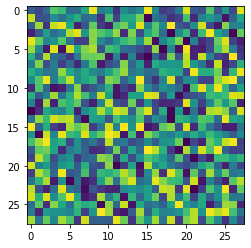

In [6]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

x = torch.randn([1, 28, 28], dtype=torch.float)
im = transforms.ToPILImage()(x)
plt.imshow(im)

In [9]:
x = torch.ones([1, 28, 28], dtype=torch.float)
im = transforms.ToPILImage()(x)
inf_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])
x = inf_transforms(im)

_, y = model.predict(x.unsqueeze(0))
y

NameError: name 'model' is not defined

/tmp/ipykernel_2277/1222726969.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


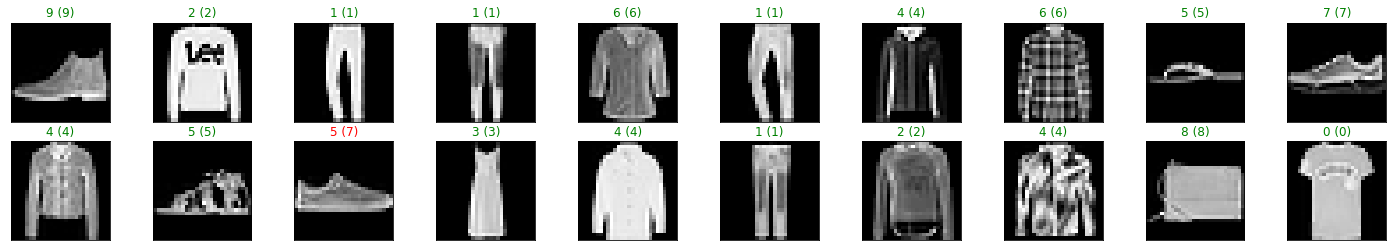

In [75]:
batch_size = 128
num_classes = 10
val_ratio = 0.15
num_workers = 8
dm = FashionMNISTDataModule(batch_size=batch_size, num_classes=num_classes, val_ratio=val_ratio, num_workers=8)
dm.setup()

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()

_, preds = model.predict(images)
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

8

In [60]:
from demo.model_server.FashionClassifier import FashionClassifier

x = np.random.rand(*[28, 28, 1])
FashionClassifier().predict(x)

tensor([8])

In [47]:
x2 = torch.ones([1, 1, 28, 28], dtype=torch.float)
